## Diabetes - data exploration

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
from PIL.features import features
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#graphs appear in notebook
%matplotlib inline
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libaries loaded")

Libaries loaded


In [171]:
data = pd.read_csv('../data/raw/diabetes.csv')

print(f"Data shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

Data shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


### Information about dataset attributes -

Pregnancies: To express the Number of pregnancies

Glucose: To express the Glucose level in blood

BloodPressure: To express the Blood pressure measurement

SkinThickness: To express the thickness of the skin

Insulin: To express the Insulin level in blood

BMI: To express the Body mass index

DiabetesPedigreeFunction: To express the Diabetes percentage

Age: To express the age

Outcome: To express the final result 1 is Yes and 0 is No

### Missing data (zero values)

In [172]:
missing = (data.drop('Outcome',axis=1)==0).sum()
missing_percent = (missing / len(data) * 100).round(1)

missing_df = pd.DataFrame({
    'Missing': missing,
    'Percent': missing_percent
})
print(missing_df.sort_values('Percent', ascending=False))

                          Missing  Percent
Insulin                       374     48.7
SkinThickness                 227     29.6
Pregnancies                   111     14.5
BloodPressure                  35      4.6
BMI                            11      1.4
Glucose                         5      0.7
DiabetesPedigreeFunction        0      0.0
Age                             0      0.0


In [173]:
columns_with_zeros = ['Pregnancies','Glucose', 'BloodPressure', 'SkinThickness','Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']
for col in columns_with_zeros:
    data[col] = data[col].replace(0,np.nan)

### Data imputation (Iterative Imputer)

In [174]:
data = data.copy()

columns_to_impute = [
'Pregnancies', 'Glucose','BloodPressure', 'SkinThickness','Insulin','BMI',
]
all_columns = columns_to_impute + ['DiabetesPedigreeFunction',	'Age']

imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=50, random_state=42, max_depth=10),
    max_iter=10,  
    random_state=42,
    verbose=1 #print logs
)

data_imputed = data.copy()
data_imputed[all_columns] = imputer.fit_transform(data[all_columns])

data_imputed['Pregnancies'] = data_imputed['Pregnancies'].round().astype(int).clip(lower=0)
data_imputed['Glucose'] = data_imputed['Glucose'].clip(lower=0)
data_imputed['BloodPressure'] = data_imputed['BloodPressure'].clip(lower=30, upper=200)
data_imputed['SkinThickness'] = data_imputed['SkinThickness'].clip(lower=0)
data_imputed['Insulin'] = data_imputed['Insulin'].clip(lower=0)
data_imputed['BMI'] = data_imputed['BMI'].clip(lower=15, upper=60)



[IterativeImputer] Completing matrix with shape (768, 8)
[IterativeImputer] Change: 396.0997766497462, scaled tolerance: 0.846 
[IterativeImputer] Change: 34.93366524198001, scaled tolerance: 0.846 
[IterativeImputer] Change: 40.91319444444447, scaled tolerance: 0.846 
[IterativeImputer] Change: 46.697700170602346, scaled tolerance: 0.846 
[IterativeImputer] Change: 62.200000000000045, scaled tolerance: 0.846 
[IterativeImputer] Change: 53.750471006131384, scaled tolerance: 0.846 
[IterativeImputer] Change: 69.78938496254713, scaled tolerance: 0.846 
[IterativeImputer] Change: 66.92610007570694, scaled tolerance: 0.846 
[IterativeImputer] Change: 41.65336904761901, scaled tolerance: 0.846 
[IterativeImputer] Change: 50.120000000000005, scaled tolerance: 0.846 


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Compare imputed data to original data 

In [175]:
data_imputed = data_imputed.copy()
data_original = data.copy()
for col in columns_to_impute:
    print(col)
    print(f'original data: {data_original[col].mean()}') 
    print(f'imputed data: {data_imputed[col].mean()}')

data_imputed.to_csv('../data/processed/data_imputed.csv')

Pregnancies
original data: 4.494672754946728
imputed data: 4.29296875
Glucose
original data: 121.6867627785059
imputed data: 121.59374995773135
BloodPressure
original data: 72.40518417462484
imputed data: 72.38669579479928
SkinThickness
original data: 29.153419593345657
imputed data: 28.998439159418798
Insulin
original data: 155.5482233502538
imputed data: 157.67256143668845
BMI
original data: 32.457463672391015
imputed data: 32.44040924507961


### Check distribution (Histogram)

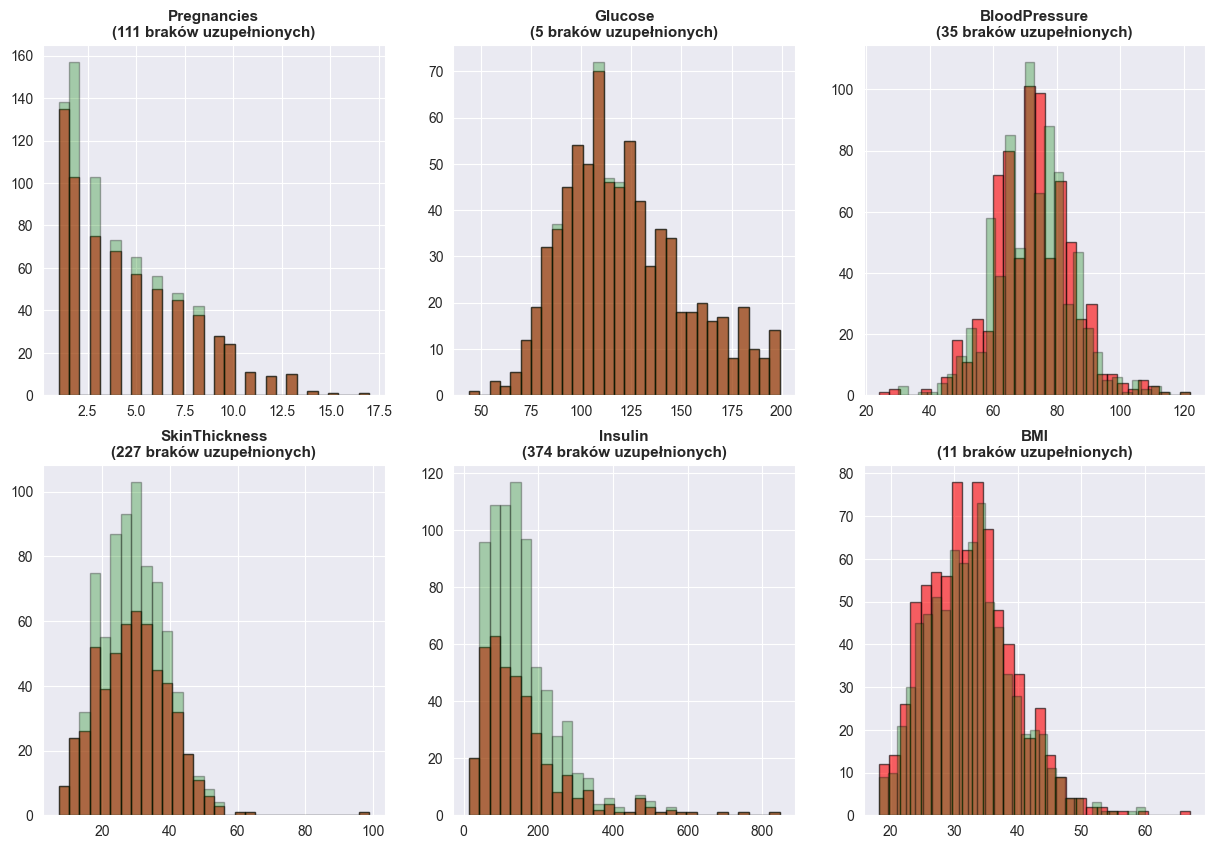

In [176]:
data_imputed = data_imputed.copy()
data_original = data.copy()

columns_to_show = columns_to_impute

fig, axes = plt.subplots(2,3,figsize=(15,10))
axes = axes.ravel()

for idx,col in enumerate(columns_to_show):
    ax = axes[idx]#current graph
    
    data_original[col].dropna().hist(
        #current graph
        ax = ax,
        bins = 30,
        alpha = 0.6,
        label = "Original",
        color = "red",
        edgecolor='black'
    )
    
    data_imputed[col].hist(
        ax = ax,
        bins = 30,
        alpha = 0.3,
        label = "Imputed",
        color = "green",
        edgecolor='black'
    )
    ax.set_title(f'{col}\n({data_original[col].isna().sum()} braków uzupełnionych)', 
             fontsize=11, fontweight='bold')



## Modelling

In [177]:
#normal data
data = data_imputed.copy()
features = all_columns

X = data[features]
Y = data['Outcome']

X_train, X_val, Y_train, Y_val = train_test_split(
    X,Y,
    test_size=0.2,
    random_state=42
)

#data without 'Insulin' column
data_without_insulin = data.drop('Insulin',axis=1)
features_ni = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
               'BMI', 'DiabetesPedigreeFunction', 'Age']



X = data_without_insulin[features_ni]
Y = data_without_insulin['Outcome']

X_train_ni, X_val_ni, Y_train_ni, Y_val_ni = train_test_split(
    X,Y,
    test_size=0.2,
    random_state=42
)


#### Random Forest Classsifier

In [178]:
rf_model = RandomForestClassifier(
    n_estimators=100,      # num of trees
    max_depth=10,          # max tree depth
    min_samples_split=5,   # min samples to split
    random_state=42
)

rf_model.fit(X_train,Y_train)
rf_predictions = rf_model.predict(X_val)
rf_accuracy = accuracy_score(Y_val,rf_predictions)

print(f"\nRandom Forrest Accuracy: {rf_accuracy:.2%}")
feature_importance = sorted(list(zip(features, rf_model.feature_importances_)),
                           key=lambda x: x[1], reverse=True)
for name, importance in feature_importance:
    print(f'{name:<15}: {importance*100:.3f}')


Random Forrest Accuracy: 74.03%
Glucose        : 24.157
Insulin        : 18.117
BMI            : 13.984
Age            : 11.788
DiabetesPedigreeFunction: 9.740
SkinThickness  : 9.646
BloodPressure  : 6.626
Pregnancies    : 5.943


#### Random Forest Classsifier (without 'Insuline')


In [179]:
rf_model = RandomForestClassifier(
    n_estimators=100,      # num of trees
    max_depth=10,          # max tree depth
    min_samples_split=5,   # min samples to split
    random_state=42
)

rf_model.fit(X_train_ni,Y_train_ni)
rf_predictions = rf_model.predict(X_val_ni)
rf_accuracy = accuracy_score(Y_val_ni,rf_predictions)

print(f"\nRandom Forrest Accuracy: {rf_accuracy:.2%}")
feature_importance = sorted(list(zip(features_ni, rf_model.feature_importances_)),
                           key=lambda x: x[1], reverse=True)
for name, importance in feature_importance:
    print(f'{name:<15}: {importance*100:.3f}')


Random Forrest Accuracy: 76.62%
Glucose        : 30.831
BMI            : 15.519
Age            : 14.750
SkinThickness  : 12.164
DiabetesPedigreeFunction: 12.056
BloodPressure  : 7.755
Pregnancies    : 6.925


## Results
- **With Insulin**: 74.03% accuracy
- **Without Insulin**: 76.62% accuracy 

#### Why Exclusion of Insulin Improved Performance

**High imputation rate**: 374/768 values (48.7%) were model predictions, not measurements

**Poor imputation quality**: Histograms show artificial concentration around mean values vs. original dispersed distribution

**Feature redundancy**: Insulin strongly correlates with Glucose and BMI already in dataset. 

**Low signal-to-noise ratio**: ~50% real signal, ~50% prediction errors